In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
image_size = 300
batch_size = 16

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

train_path_second = '../input/more-cassava-disease/train/train/train'

In [4]:
second_id = []
second_label = []

for img in os.listdir(os.path.join(train_path_second, 'cbb')):
    second_id.append('/cbb/'+img)
    second_label.append('0')
    
for img in os.listdir(os.path.join(train_path_second, 'cbsd')):
    second_id.append('/cbsd/'+img)
    second_label.append('1')
    
for img in os.listdir(os.path.join(train_path_second, 'cgm')):
    second_id.append('/cgm/'+img)
    second_label.append('2')
    
for img in os.listdir(os.path.join(train_path_second, 'cmd')):
    second_id.append('/cmd/'+img)
    second_label.append('3')
    
for img in os.listdir(os.path.join(train_path_second, 'healthy')):
    second_id.append('/healthy/'+img)
    second_label.append('4')

In [5]:
train_second = pd.DataFrame({'image_id':second_id, 'label':second_label})

train_second.head()

,image_id,label
0,/cbb/train-cbb-0.jpg,0
1,/cbb/train-cbb-1.jpg,0
2,/cbb/train-cbb-10.jpg,0
3,/cbb/train-cbb-100.jpg,0
4,/cbb/train-cbb-101.jpg,0


In [6]:
del second_id
del second_label

In [7]:
def image_path_first(image):
    return os.path.join(train_path,image)

def image_path_second(image):
    return os.path.join(train_path_second, image)

train['image_id'] = train['image_id'].apply(image_path_first)
train_second['image_id'] = train_second['image_id'].apply(image_path_second)

In [8]:
train['label'] = train['label'].astype('str')

In [9]:
# combine dataframe to train

combined_train = pd.concat([train, train_second], ignore_index=True)

combined_train.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


In [10]:
combined_train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [11]:
del train
del train_second

train = combined_train

del combined_train
del train_path
del train_path_second

In [12]:
train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [13]:
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [14]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                rescale = 1./255)

val_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale=1./255)

In [15]:
def build_vgg16():
    model = Sequential()
    model.add(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


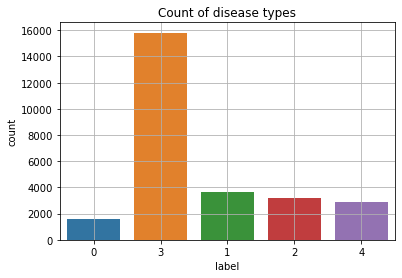

In [16]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [17]:
fold_var = 1

In [18]:
for train_idx, val_idx in SKF.split(train, train['label']):
    training_data = train.iloc[train_idx]
    validation_data = train.iloc[val_idx]
    
    # generator
    train_generator = train_gen.flow_from_dataframe(dataframe=training_data, directory=None, x_col='image_id', y_col='label',
                                                batch_size=batch_size, seed=1, shuffle=True,
                                                class_mode='categorical', target_size=(image_size,image_size))

    validation_generator = val_gen.flow_from_dataframe(dataframe=validation_data, directory=None, x_col='image_id', y_col='label',
                                                   batch_size=batch_size, seed=1, shuffle=False,
                                                   class_mode='categorical', target_size=(image_size,image_size))
    
    print('Fold num:', fold_var)
    print('Train length:', len(train_generator))
    print('Val length:', len(validation_generator))
    
    # build model
    model = build_vgg16()
    
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    # callbacks
    checkpoint_filename = './k_fold_vgg/checkpoint_' + str(fold_var) + '.h5'
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=1, min_lr=0, verbose=1)
    
    # fit
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1,
                        batch_size=batch_size,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
                        
    # save model
    model_filename = './k_fold_vgg/' + str(fold_var) + '.h5'
    model.save(model_filename)
    
    clear_session()
    fold_var += 1

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4532 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17110 validated image filenames belonging to 5 classes.


C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1124 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 4287 validated image filenames belonging to 5 classes.
Fold num: 1
Train length: 1070
Val length: 268
Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 0.9434 - accuracy: 0.6601
Epoch 00001: val_loss improved from inf to 0.78808, saving model to ./k_fold_vgg\checkpoint_1.h5
1070/1070 [==============================] - 419s 392ms/step - loss: 0.9434 - accuracy: 0.6601 - val_loss: 0.7881 - val_accuracy: 0.7108
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.7400
Epoch 00002: val_loss improved from 0.78808 to 0.59684, saving model to ./k_fold_vgg\checkpoint_1.h5
1070/1070 [==============================] - 362s 338ms/step - loss: 0.7245 - accuracy: 0.7400 - val_loss: 0.5968 - val_accuracy: 0.7896
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.7826
Epoch 00003: val_loss did not improve from 0.59684

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.999999949475750

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4491 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1165 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17151 validated image filenames belonging to 5 classes.
Found 4246 validated image filenames belonging to 5 classes.
Fold num: 2
Train length: 1072
Val length: 266
Epoch 1/30
1072/1072 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.6462
Epoch 00001: val_loss improved from inf to 0.79360, saving model to ./k_fold_vgg\checkpoint_2.h5
1072/1072 [==============================] - 359s 335ms/step - loss: 0.9811 - accuracy: 0.6462 - val_loss: 0.7936 - val_accuracy: 0.6931
Epoch 2/30
1072/1072 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7437
Epoch 00002: val_loss improved from 0.79360 to 0.71126, saving model to ./k_fold_vgg\checkpoint_2.h5
1072/1072 [==============================] - 360s 336ms/step - loss: 0.7123 - accuracy: 0.7437 - val_loss: 0.7113 - val_accuracy: 0.7579
Epoch 3/30
1072/1072 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.7811
Epoch 00003: val_loss improved from 0.71126 to 0.58659, saving m

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4470 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1186 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17172 validated image filenames belonging to 5 classes.
Found 4225 validated image filenames belonging to 5 classes.
Fold num: 3
Train length: 1074
Val length: 265
Epoch 1/30
1074/1074 [==============================] - ETA: 0s - loss: 0.9754 - accuracy: 0.6462
Epoch 00001: val_loss improved from inf to 0.72012, saving model to ./k_fold_vgg\checkpoint_3.h5
1074/1074 [==============================] - 403s 375ms/step - loss: 0.9754 - accuracy: 0.6462 - val_loss: 0.7201 - val_accuracy: 0.7271
Epoch 2/30
1074/1074 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7452
Epoch 00002: val_loss improved from 0.72012 to 0.63304, saving model to ./k_fold_vgg\checkpoint_3.h5
1074/1074 [==============================] - 355s 330ms/step - loss: 0.7141 - accuracy: 0.7452 - val_loss: 0.6330 - val_accuracy: 0.7688
Epoch 3/30
1074/1074 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7809
Epoch 00003: val_loss improved from 0.63304 to 0.58187, saving m

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4563 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1093 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17080 validated image filenames belonging to 5 classes.
Found 4317 validated image filenames belonging to 5 classes.
Fold num: 4
Train length: 1068
Val length: 270
Epoch 1/30
1068/1068 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6539
Epoch 00001: val_loss improved from inf to 0.69285, saving model to ./k_fold_vgg\checkpoint_4.h5
1068/1068 [==============================] - 361s 338ms/step - loss: 0.9492 - accuracy: 0.6539 - val_loss: 0.6928 - val_accuracy: 0.7582
Epoch 2/30
1068/1068 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.7478
Epoch 00002: val_loss improved from 0.69285 to 0.56300, saving model to ./k_fold_vgg\checkpoint_4.h5
1068/1068 [==============================] - 358s 335ms/step - loss: 0.7075 - accuracy: 0.7478 - val_loss: 0.5630 - val_accuracy: 0.8015
Epoch 3/30
1068/1068 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7877
Epoch 00003: val_loss improved from 0.56300 to 0.53757, saving m

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4568 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1088 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17075 validated image filenames belonging to 5 classes.
Found 4322 validated image filenames belonging to 5 classes.
Fold num: 5
Train length: 1068
Val length: 271
Epoch 1/30
1068/1068 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.6577
Epoch 00001: val_loss improved from inf to 0.71775, saving model to ./k_fold_vgg\checkpoint_5.h5
1068/1068 [==============================] - 362s 339ms/step - loss: 0.9416 - accuracy: 0.6577 - val_loss: 0.7177 - val_accuracy: 0.7230
Epoch 2/30
1068/1068 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7507
Epoch 00002: val_loss improved from 0.71775 to 0.57922, saving model to ./k_fold_vgg\checkpoint_5.h5
1068/1068 [==============================] - 361s 338ms/step - loss: 0.7137 - accuracy: 0.7507 - val_loss: 0.5792 - val_accuracy: 0.7832
Epoch 3/30
1068/1068 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7724
Epoch 00003: val_loss did not improve from 0.57922

Epoch 00003:

In [19]:
test = pd.read_csv('../input/more-cassava-disease/sample_submission_file.csv')

In [20]:
test_path = '../input/more-cassava-disease/test/test/test/0'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)
test['label'].replace('cbb', '0', inplace=True)
test['label'].replace('cbsd', '1', inplace=True)
test['label'].replace('cgm', '2', inplace=True)
test['label'].replace('cmd', '3', inplace=True)
test['label'].replace('healthy', '4', inplace=True)

In [21]:
test_generator = val_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 3774 validated image filenames belonging to 5 classes.


In [22]:
output = model.predict(test_generator)
output = np.argmax(output, axis=1)

In [23]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, output, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

              precision    recall  f1-score   support

         CBB       0.21      0.04      0.07       753
        CBSD       0.19      0.17      0.18       731
         CGM       0.20      0.22      0.21       706
         CMD       0.21      0.43      0.29       800
     Healthy       0.21      0.16      0.18       784

    accuracy                           0.21      3774
   macro avg       0.20      0.20      0.18      3774
weighted avg       0.20      0.21      0.18      3774

